# Data Cleaning

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [5]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
df.shape, df.columns

((525461, 8),
 Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country'], dtype='str'))

In [7]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[us]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), object(3), str(1)
memory usage: 32.1+ MB


In [8]:
df.isna().sum().sort_values(ascending=False).head(10)

Customer ID    107927
Description      2928
StockCode           0
Invoice             0
Quantity            0
InvoiceDate         0
Price               0
Country             0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(6865)

Standarize Columns

In [10]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
#Convert type
df["invoicedate"] = pd.to_datetime(df["invoicedate"])
df["customer_id"] = df["customer_id"].astype("Int64")  # keeps NaNs safely

#Remove canceled invoices
df = df[~df["invoice"].astype(str).str.startswith("C")]

#Remove returns/ invalid rows
df = df[(df["quantity"] > 0) & (df["price"] > 0)]

# Remove missing customer id
df = df.dropna(subset=["customer_id"])

#Create revenue column
df["revenue"] = df["quantity"] * df["price"]

#Remove duplicate(if any)
df = df.drop_duplicates()

In [12]:
df.shape

(400916, 9)

In [13]:
df[["quantity", "price", "revenue"]].describe()

,quantity,price,revenue
count,400916.000000,400916.000000,400916.000000
mean,13.767418,3.305826,21.945330
std,97.638385,35.047719,77.758075
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,5.000000
50%,5.000000,1.950000,12.500000
75%,12.000000,3.750000,19.500000
max,19152.000000,10953.500000,15818.400000


In [14]:
#clean dataset
df.to_csv('online_retail_clean.csv', index=False)

In [15]:
df.isna().sum().sort_values(ascending=False).head(5)

invoice        0
stockcode      0
description    0
quantity       0
invoicedate    0
dtype: int64

# Business EDA

In [16]:
# total revenue
df["revenue"].sum()

np.float64(8798233.743999999)

In [17]:
df.groupby("country")["revenue"].sum().sort_values(ascending=False).head(10)

country
United Kingdom    7381644.433
EIRE               356041.860
Netherlands        268784.350
Germany            202025.391
France             146107.070
Sweden              53147.990
Denmark             50906.850
Spain               47568.650
Switzerland         43921.390
Australia           31446.800
Name: revenue, dtype: float64

<Axes: xlabel='year_month'>

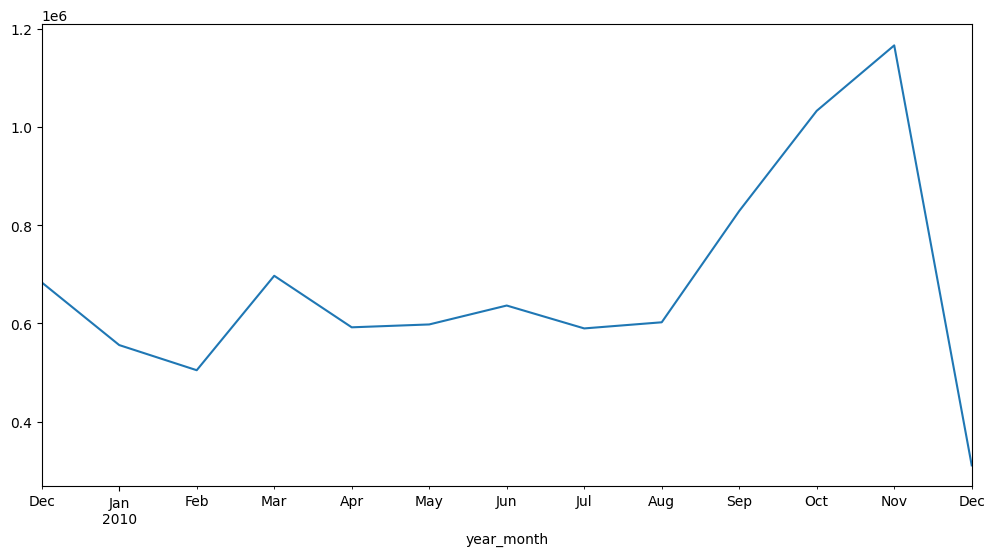

In [18]:
df["year_month"] = df["invoicedate"].dt.to_period("M")

monthly_revenue = (
    df.groupby("year_month")["revenue"]
    .sum()
    .sort_index()
)

monthly_revenue.plot(figsize=(12,6))

In [19]:
df.groupby("description")["revenue"] \
  .sum() \
  .sort_values(ascending=False) \
  .head(5)

description
WHITE HANGING HEART T-LIGHT HOLDER    151339.16
REGENCY CAKESTAND 3 TIER              143727.60
Manual                                 98531.99
ASSORTED COLOUR BIRD ORNAMENT          70291.03
JUMBO BAG RED RETROSPOT                51644.25
Name: revenue, dtype: float64

# Summary
    The company generated £8.8M revenue, with 84% concentrated in the UK market. Revenue shows strong seasonality with a significant spike in Quarter 4, suggesting heavy dependence on holiday sales.

In [20]:
customer_revenue = df.groupby("customer_id")["revenue"].sum().sort_values(ascending=False)

top_10_percent_cutoff = int(len(customer_revenue) * 0.1)

top_10_revenue = customer_revenue.head(top_10_percent_cutoff).sum()
total_revenue = customer_revenue.sum()

top_10_revenue / total_revenue

np.float64(0.5991726486688349)

# RFM Segmentation

In [21]:
# creating reference date
reference_date = df["invoicedate"].max() + pd.Timedelta(days=1)
reference_date

Timestamp('2010-12-10 20:01:00')

In [22]:
# RFM table
rfm = df.groupby("customer_id").agg({
    "invoicedate": lambda x: (reference_date - x.max()).days,  # Recency
    "invoice": "nunique",                                   # Frequency
    "revenue": "sum"                                           # Monetary
})

rfm.columns = ["recency", "frequency", "monetary"]

rfm.head()

,recency,frequency,monetary
customer_id,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93


In [23]:
rfm.shape

(4312, 3)

In [24]:
rfm.describe()

,recency,frequency,monetary
count,4312.000000,4312.000000,4312.000000
mean,91.171846,4.455705,2040.406712
std,96.860633,8.170213,8911.755977
min,1.000000,1.000000,2.950000
25%,18.000000,1.000000,307.187500
50%,53.000000,2.000000,701.615000
75%,136.000000,5.000000,1714.932500
max,374.000000,205.000000,349164.350000


In [25]:
# scale RFM
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    columns=["recency", "frequency", "monetary"],
    index=rfm.index
)

rfm_scaled.head()

,recency,frequency,monetary
customer_id,,,
12346,0.762299,0.801087,-0.187139
12347,-0.910402,-0.300603,-0.080475
12348,-0.177305,-0.423013,-0.204052
12349,-0.497389,-0.178193,0.070784
12351,-0.827799,-0.423013,-0.195212


In [26]:
rfm_scaled.describe()

,recency,frequency,monetary
count,4.312000e+03,4.312000e+03,4.312000e+03
mean,5.602610e-17,5.932175e-17,2.306957e-17
std,1.000116e+00,1.000116e+00,1.000116e+00
min,-9.310522e-01,-4.230129e-01,-2.286522e-01
25%,-7.555219e-01,-4.230129e-01,-1.945094e-01
50%,-3.941361e-01,-3.006029e-01,-1.502450e-01
75%,4.628645e-01,6.662716e-02,-3.652613e-02
max,2.920288e+00,2.454863e+01,3.895576e+01


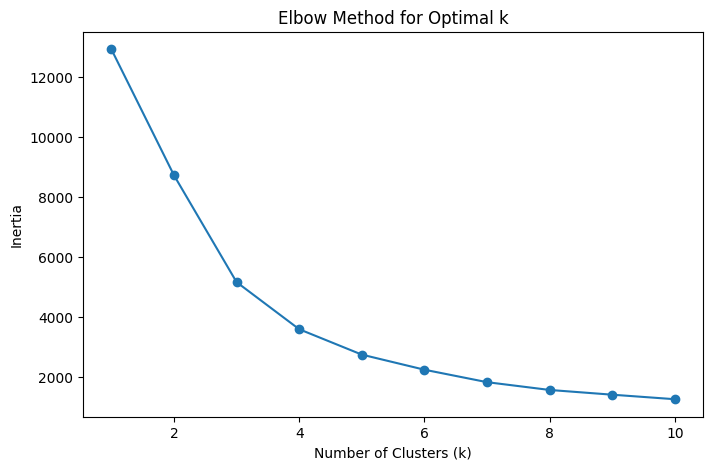

In [27]:
inertia = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [28]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)

rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,recency,frequency,monetary,cluster
customer_id,,,,
12346,165,11,372.86,1
12347,3,2,1323.32,0
12348,74,1,222.16,0
12349,43,3,2671.14,0
12351,11,1,300.93,0


In [29]:
rfm.groupby("cluster").mean()

,recency,frequency,monetary
cluster,,,
0,43.031835,4.455056,1710.650030
1,242.976122,1.659981,593.540319
2,5.600000,113.600000,215535.000000
3,14.910714,47.017857,28896.416661


In [30]:
rfm["cluster"].value_counts()

cluster
0    3204
1    1047
3      56
2       5
Name: count, dtype: int64

In [31]:
cluster_revenue = rfm.groupby("cluster")["monetary"].sum()

cluster_revenue / cluster_revenue.sum()

cluster
0    0.622957
1    0.070632
2    0.122488
3    0.183923
Name: monetary, dtype: float64

Customer segmentation revealed extreme revenue concentration, where only 1.4% of customers(cluster2 & 3) contribute over 30% of total revenue. This highlights the critical importance of retention strategies for high-value customers while optimizing marketing spend on low-contributing segments.

In [32]:
cluster_names = {
    2: "Elite / Wholesale",
    3: "VIP Loyal",
    0: "Regular",
    1: "At-Risk / Lost"
}

rfm["segment"] = rfm["cluster"].map(cluster_names)

rfm[["recency", "frequency", "monetary", "cluster", "segment"]].head()

,recency,frequency,monetary,cluster,segment
customer_id,,,,,
12346,165,11,372.86,1,At-Risk / Lost
12347,3,2,1323.32,0,Regular
12348,74,1,222.16,0,Regular
12349,43,3,2671.14,0,Regular
12351,11,1,300.93,0,Regular


In [33]:
rfm["segment"].value_counts()

segment
Regular              3204
At-Risk / Lost       1047
VIP Loyal              56
Elite / Wholesale       5
Name: count, dtype: int64

In [34]:
segment_summary = rfm.groupby("segment").agg(
    customers=("segment", "count"),
    avg_recency=("recency", "mean"),
    avg_frequency=("frequency", "mean"),
    avg_monetary=("monetary", "mean"),
    total_revenue=("monetary", "sum")
).sort_values("total_revenue", ascending=False)

segment_summary["revenue_share"] = segment_summary["total_revenue"] / segment_summary["total_revenue"].sum()
segment_summary

,customers,avg_recency,avg_frequency,avg_monetary,total_revenue,revenue_share
segment,,,,,,
Regular,3204,43.031835,4.455056,1710.650030,5480922.697,0.622957
VIP Loyal,56,14.910714,47.017857,28896.416661,1618199.333,0.183923
Elite / Wholesale,5,5.600000,113.600000,215535.000000,1077675.000,0.122488
At-Risk / Lost,1047,242.976122,1.659981,593.540319,621436.714,0.070632


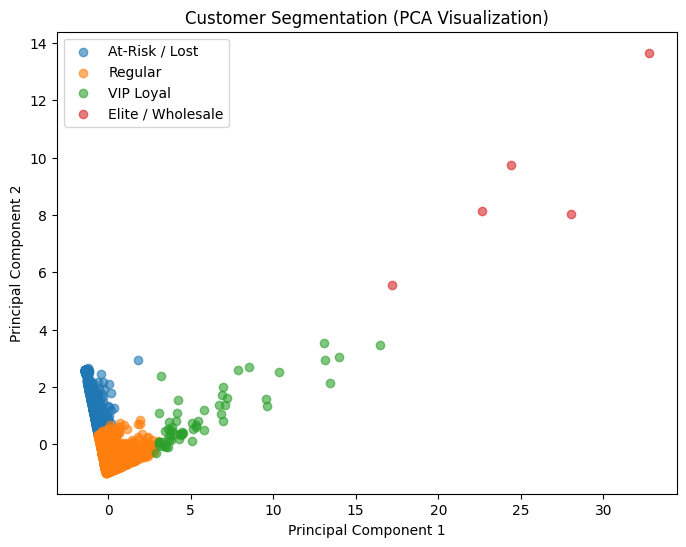

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

rfm_pca = pd.DataFrame(rfm_pca, columns=["PC1", "PC2"])
rfm_pca["segment"] = rfm["segment"].values

plt.figure(figsize=(8,6))

for segment in rfm_pca["segment"].unique():
    subset = rfm_pca[rfm_pca["segment"] == segment]
    plt.scatter(subset["PC1"], subset["PC2"], label=segment, alpha=0.6)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segmentation (PCA Visualization)")
plt.legend()
plt.show()

In [36]:
rfm["churn"] = (rfm["recency"] > 90).astype(int)

rfm["churn"].value_counts()
# 1 = churned
# 0 = active

churn
0    2877
1    1435
Name: count, dtype: int64

In [37]:
X = rfm[["recency", "frequency", "monetary"]]
y = rfm["churn"]

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((3018, 3), (1294, 3))

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

[[852   0]
 [ 15 427]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       852
           1       1.00      0.97      0.98       442

    accuracy                           0.99      1294
   macro avg       0.99      0.98      0.99      1294
weighted avg       0.99      0.99      0.99      1294

AUC: 1.0


Although the initial churn model achieved extremely high performance metrics (99% accuracy and AUC = 1.0), these results were unrealistically perfect due to data leakage. Churn was defined directly using the Recency variable (recency > 90), while Recency was also included as a feature in the model. As a result, the model simply learned the exact rule used to create the churn label rather than identifying meaningful behavioral patterns. This means the model was explaining past inactivity instead of predicting future churn, which would not work in a real-world business setting. To build a valid and deployable churn model, we must instead use a time-based approach,creating features from historical data and defining churn based on future behavior,so that the model truly predicts customer attrition rather than memorizing a predefined rule.


In [42]:
df["invoicedate"].min(), df["invoicedate"].max()

(Timestamp('2009-12-01 07:45:00'), Timestamp('2010-12-09 20:01:00'))

In [43]:
cutoff_date = pd.Timestamp("2010-09-01")

df_before = df[df["invoicedate"] < cutoff_date]
df_after = df[df["invoicedate"] >= cutoff_date]

df_before.shape, df_after.shape

((244976, 10), (155940, 10))

In [44]:
reference_date = cutoff_date

rfm_before = df_before.groupby("customer_id").agg({
    "invoicedate": lambda x: (reference_date - x.max()).days,
    "invoice": "nunique",
    "revenue": "sum"
})

rfm_before.columns = ["recency", "frequency", "monetary"]
rfm_before.head()

,recency,frequency,monetary
customer_id,,,
12346,64,11,372.86
12349,105,2,1268.52
12355,102,1,488.21
12358,85,2,1697.93
12359,70,5,2012.03


In [45]:
customers_after = df_after["customer_id"].unique()

rfm_before["churn"] = ~rfm_before.index.isin(customers_after)
rfm_before["churn"] = rfm_before["churn"].astype(int)

rfm_before["churn"].value_counts()

churn
0    1995
1    1326
Name: count, dtype: int64

In [46]:
df_before.shape 

(244976, 10)

In [47]:
df_after.shape

(155940, 10)

In [48]:
rfm_before.shape

(3321, 4)

In [49]:
rfm_before["churn"].value_counts()

churn
0    1995
1    1326
Name: count, dtype: int64

In [50]:
X = rfm_before[["recency", "frequency", "monetary"]]
y = rfm_before["churn"]

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [54]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

[[473 137]
 [198 189]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       610
           1       0.58      0.49      0.53       387

    accuracy                           0.66       997
   macro avg       0.64      0.63      0.63       997
weighted avg       0.66      0.66      0.66       997

AUC: 0.7214385563604016


In [55]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [56]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

[[357 253]
 [102 285]]
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       610
           1       0.53      0.74      0.62       387

    accuracy                           0.64       997
   macro avg       0.65      0.66      0.64       997
weighted avg       0.68      0.64      0.65       997

AUC: 0.7214258482653451


Developed a time-based churn prediction model using logistic regression, achieving AUC of 0.72 and improving churn recall from 49% to 74% using class balancing techniques.

# Time-Based Churn Modeling

In [57]:
cutoff_date = pd.Timestamp("2010-09-01")
window_days = 60
end_date = cutoff_date + pd.Timedelta(days=window_days)

# Past data to define segments / baseline
df_before = df[df["invoicedate"] < cutoff_date].copy()

# Future window to measure outcomes
df_window = df[(df["invoicedate"] >= cutoff_date) & (df["invoicedate"] < end_date)].copy()

df_before.shape, df_window.shape

((244976, 10), (80245, 10))

In [58]:
# Build RFM from before period
reference_date = cutoff_date
rfm_before = df_before.groupby("customer_id").agg({
    "invoicedate": lambda x: (reference_date - x.max()).days,
    "invoice": "nunique",
    "revenue": "sum"
})
rfm_before.columns = ["recency", "frequency", "monetary"]

# Scale + KMeans (k=4)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_before)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_before["cluster"] = kmeans.fit_predict(rfm_scaled)

# Map clusters to business segments (we'll auto-map based on means)
cluster_means = rfm_before.groupby("cluster")[["recency","frequency","monetary"]].mean()

elite_cluster = cluster_means["monetary"].idxmax()
atrisk_cluster = cluster_means["recency"].idxmax()
vip_cluster = cluster_means.drop(index=[elite_cluster, atrisk_cluster])["frequency"].idxmax()
regular_cluster = [c for c in cluster_means.index if c not in [elite_cluster, atrisk_cluster, vip_cluster]][0]

cluster_names = {
    elite_cluster: "Elite / Wholesale",
    vip_cluster: "VIP Loyal",
    regular_cluster: "Regular",
    atrisk_cluster: "At-Risk / Lost"
}

rfm_before["segment"] = rfm_before["cluster"].map(cluster_names)

rfm_before["segment"].value_counts(), cluster_means

(segment
 Regular              2117
 At-Risk / Lost       1164
 VIP Loyal              35
 Elite / Wholesale       5
 Name: count, dtype: int64,
             recency  frequency       monetary
 cluster                                      
 0         44.163911   3.977326    1539.511424
 1        177.061856   1.541237     560.441034
 2         13.228571  40.685714   22169.270914
 3          7.600000  78.000000  154313.572000)

# A/B Testing Simulation

In [59]:
ab_pop = rfm_before[rfm_before["segment"] == "At-Risk / Lost"].copy()
ab_pop.shape

(1164, 5)

In [60]:
np.random.seed(42)

ab_pop["group"] = np.where(np.random.rand(len(ab_pop)) < 0.5, "control", "treatment")
ab_pop["group"].value_counts()

group
treatment    589
control      575
Name: count, dtype: int64

In [61]:
# Revenue per customer in the future window
future_rev = df_window.groupby("customer_id")["revenue"].sum()

ab_pop["future_revenue"] = ab_pop.index.map(future_rev).fillna(0.0)
ab_pop["converted"] = (ab_pop["future_revenue"] > 0).astype(int)

ab_pop.groupby("group")[["converted","future_revenue"]].mean()

,converted,future_revenue
group,,
control,0.274783,140.925339
treatment,0.305603,191.953056


In [ ]:
# Conversion test
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import numpy as np

ctrl = ab_pop[ab_pop["group"]=="control"]
treat = ab_pop[ab_pop["group"]=="treatment"]

x = np.array([treat["converted"].sum(), ctrl["converted"].sum()])
n = np.array([len(treat), len(ctrl)])

z_stat, p_val = proportions_ztest(count=x, nobs=n, alternative="larger")

p_t = x[0]/n[0]
p_c = x[1]/n[1]
lift = p_t - p_c

p_t, p_c, lift, z_stat, p_val

(np.float64(0.30560271646859083),
 np.float64(0.2747826086956522),
 np.float64(0.030820107772938643),
 np.float64(1.1581207399204112),
 np.float64(0.12340738369547571))

The treatment group showed a higher conversion rate (30.56%) compared to the control group (27.48%), resulting in a lift of 3.08 percentage points. However, the p-value of 0.123 indicates that this difference is not statistically significant at the 95% confidence level. While the observed lift suggests a positive directional effect, there is insufficient statistical evidence to conclude that the discount meaningfully increased the probability of conversion among at-risk customers.

In [63]:
# Revenue test
from scipy.stats import ttest_ind

t_stat, p_rev = ttest_ind(
    treat["future_revenue"],
    ctrl["future_revenue"],
    equal_var=False,
    alternative="greater"
)

treat_mean = treat["future_revenue"].mean()
ctrl_mean = ctrl["future_revenue"].mean()
mean_lift = treat_mean - ctrl_mean

treat_mean, ctrl_mean, mean_lift, p_rev

(np.float64(191.95305602716468),
 np.float64(140.9253391304348),
 np.float64(51.027716896729885),
 np.float64(0.0451316326882854))

The treatment group generated a higher average revenue per customer (£191.95) compared to the control group (£140.93), producing a revenue lift of £51.03. With a p-value of 0.045, this difference is statistically significant at the 5% level. This suggests that while the discount may not substantially increase the number of customers who convert, it appears to increase spending among those who do purchase, indicating a positive revenue impact.

In [64]:
# Bootstrap CI
rng = np.random.default_rng(42)

B = 5000
lifts = np.empty(B)

t_vals = treat["future_revenue"].values
c_vals = ctrl["future_revenue"].values

for i in range(B):
    lifts[i] = rng.choice(t_vals, size=len(t_vals), replace=True).mean() - \
               rng.choice(c_vals, size=len(c_vals), replace=True).mean()

ci_lift = (np.percentile(lifts, 2.5), np.percentile(lifts, 97.5))
ci_lift

(np.float64(-2.679318725917138), np.float64(113.97219188971727))

The 95% bootstrap confidence interval for the revenue lift ranged from -£2.68 to £113.97. Although the upper bound suggests meaningful upside potential, the interval slightly includes zero, indicating some uncertainty around the true effect size. This borderline interval suggests that the sample size may limit statistical power, and additional experimentation with a larger customer group would help confirm the robustness of the revenue improvement.